# Tutorial 2: Interactive Workflow With Multiple Arc Spectra

This tutorial demonstrates the interactive wavelength calibration workflow using multiple arc lamp
spectra observed with the [Gran Telescopio Canarias (GTC)](https://www.gtc.iac.es/)
[Osiris spectrograph](https://www.gtc.iac.es/instruments/osiris/), and the mixing of custom line
lists with the [PypeIt](https://github.com/pypeit/PypeIt) line lists.

We'll follow the Tutorial 1 steps but use three arc lamp spectra (HgAr, Ne, and Xe) observed with
the OSIRIS R1000R grism configuration, which covers approximately 5100-10000 Å at moderate
resolution. In addition, we use a custom line list for the HgAr arc spectrum with line wavelength
values taken from the [official GTC Osiris line list](https://www.gtc.iac.es/instruments/osiris/media/lines/GTClinelist0.txt).

In [1]:
import astropy.units as u
import numpy as np

from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from matplotlib.pyplot import subplots, rc

from specreduce.compat import Spectrum
from specreduce.wavecal1d import WavelengthCalibration1D

rc('figure', figsize=(6.3, 2))

## 1.  Initialize the Wavelength Calibration Class

First, we load the data for the three arc lamps (HgAr, Ne, Xe) from the example FITS table
`osiris_arcs.fits`. We create a list of `specutils.Spectrum` objects, one for each lamp.

Next, we prepare the corresponding line lists. For the HgAr lamp, we define a custom list as a
NumPy array containing known air wavelengths specific to this GTC/OSIRIS setup, derived from the
[official GTC line list](https://www.gtc.iac.es/instruments/osiris/media/lines/GTClinelist0.txt).
For the Neon (Ne) and Xenon (Xe) lamps, we simply provide their standard identifiers (`'NeI'`,
`'XeI'`) within lists. `WavelengthCalibration1D` will use
`specreduce.calibration_data.load_pypeit_calibration_lines` internally to fetch these standard
lists.

Finally, we instantiate the `WavelengthCalibration1D` class:
- `ref_pixel=1000`: Sets the reference pixel for the polynomial fit.
- `degree=4`: Specifies a 4th-degree polynomial for the pixel-to-wavelength model.
- `arc_spectra=arc_spectra`: Provides the list of `Spectrum` objects.
- `line_lists=[hgar_lines, ['NeI'], ['XeI']]`: Provides the list of corresponding line data
(matching the size of `arc_spectra`). Note how we mix the custom array and lists of standard names.
- `line_list_bounds=(5100, 10000)`: Filters the line lists to include only lines within this approximate wavelength range (in Angstroms).
- `unit=u.angstrom`: Explicitly defines the wavelength unit.
- `wave_air=True`: Inform the class that the provided line lists (both custom and standard PypeIt lists for these lamps) contain **air** wavelengths. The class will handle conversions appropriately if needed for internal consistency or specific outputs, but the primary fitting coordinate system will be based on these air wavelengths.

In [2]:
lamps = 'HgAr', 'Ne', 'Xe'

tb = Table.read('osiris_arcs.fits')
arc_spectra = [Spectrum(tb[f'{l}_flux'].value.astype('d')*u.DN, 
                        uncertainty=StdDevUncertainty(tb[f'{l}_err'].value.astype('d'))) 
               for l in lamps]

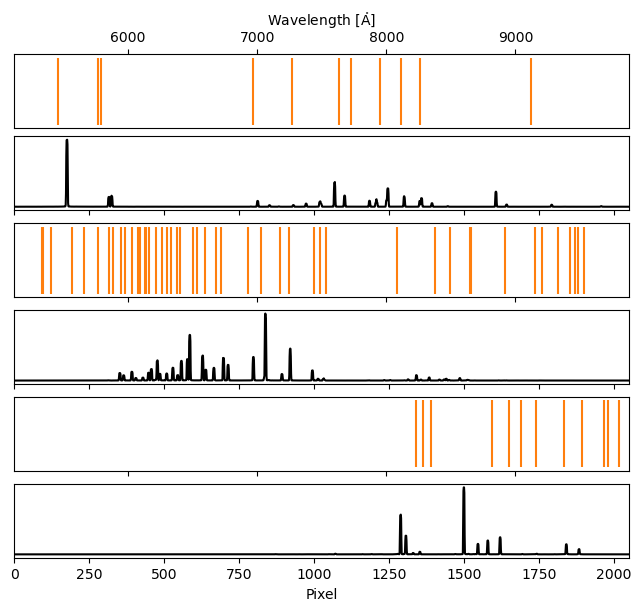

In [3]:
hgar = np.array([5460.735, 5769.598, 5790.663,  6965.431, 7272.936, 7635.106,
                 7724.207, 7948.176, 8115.311, 8264.522, 9122.967])

wc = WavelengthCalibration1D(ref_pixel=1000,
                             degree=4,
                             arc_spectra=arc_spectra,
                             line_lists=[hgar, ['NeI'], ['XeI']],
                             line_list_bounds=(5100, 9900),
                             unit=u.angstrom,
                             wave_air=True)

wc.plot_fit(figsize=(6.3, 6), plot_values=False);

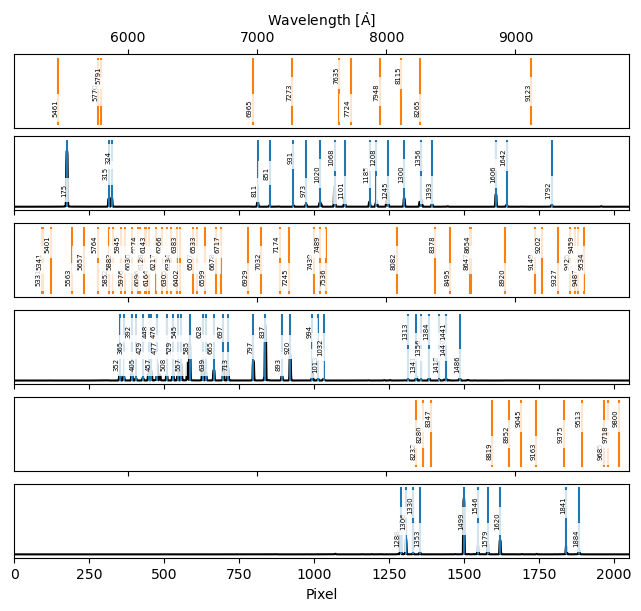

In [4]:
wc.find_lines(fwhm=4, noise_factor=15)
wc.plot_fit(figsize=(6.3, 6), value_fontsize=5);

## 2. Fit a Solution Manually

In [5]:
wc.fit_lines(pixels=[175, 797, 1499, 1579, 1620],
             wavelengths=[5461, 6931, 8822, 9048, 9165],
             match_obs=True, match_cat=True)

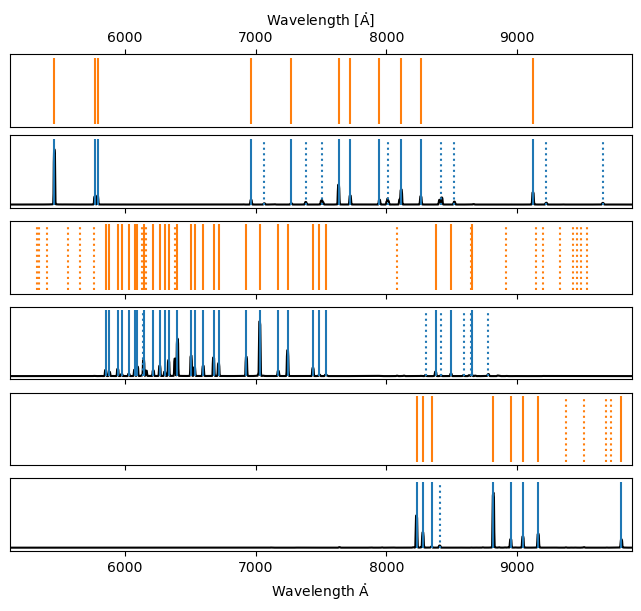

In [6]:
wc.plot_fit(figsize=(6.3, 6), plot_values=False, obs_to_wav=True);

## 3. Evaluate the Fit

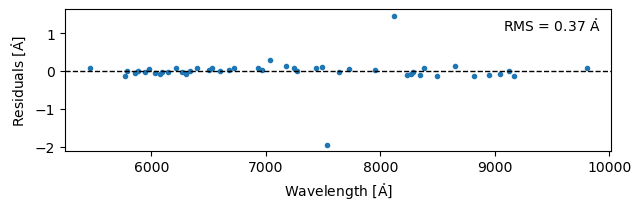

In [7]:
wc.plot_residuals(space='wavelength');

The previous fit looks good overall, with two clear outliers while the remaining lines are well-fitted. Let's refine the fit by calling `refine_fit` with a small `match_distance` parameter to deliberately exclude these outliers, then remove them completely.


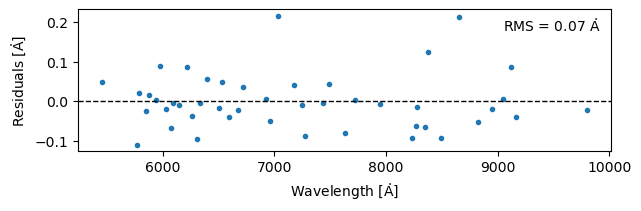

In [8]:
wc.refine_fit(max_match_distance=0.5)
wc.remove_ummatched_lines()
wc.plot_residuals(space='wavelength');

## 4. Rebin a Spectrum to Wavelength Space

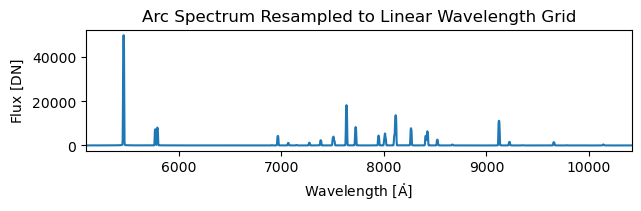

In [9]:
spectrum_wl = wc.resample(arc_spectra[0])

fig, ax = subplots(constrained_layout=True)
ax.plot(spectrum_wl.spectral_axis, spectrum_wl.flux)
ax.set_xlabel(f"Wavelength [{spectrum_wl.spectral_axis.unit.to_string('latex')}]")
ax.set_ylabel(f"Flux [{spectrum_wl.flux.unit.to_string('latex')}]")
ax.set_title("Arc Spectrum Resampled to Linear Wavelength Grid")
ax.autoscale(enable=True, axis='x', tight=True)

---